# Double Q Learning

In this notebook, we will implement Double Q Learning algorithm to play Hill Climbing.

## Step 1: Import the libraries

In [1]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque

## Step 2: Create our environment

In [2]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000
env.seed(1)

c:\users\deepanshu\.conda\envs\ai\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1]

## Step 3: Viewing our Enviroment
Execute the code cell below to play Cartpole with a random policy.

The size of state is:  (2,)
No. of Actions:  3


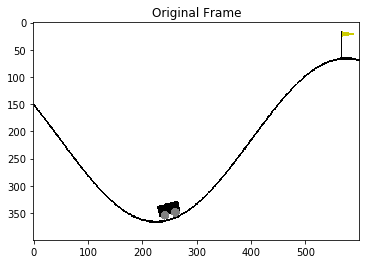

In [3]:
print("The size of state is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
env.close()
plt.title('Original Frame')
plt.show()

In [4]:
def random_play():
    env.reset()
    while True:
        env.render(mode='rgb_array')
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        if done:
            env.close()
            break
random_play()

## Step 4: Creating State Preprocess Function

In [5]:
pos_space = np.linspace(-1.2, 0.6, 12)
vel_space = np.linspace(-0.07, 0.07, 20)

def get_state(state):
    pos, vel = state
    
    pos_bin = np.digitize(pos, pos_space)
    vel_bin = np.digitize(vel, vel_space)
    return (pos_bin, vel_bin)

## Step 6: Creating out agent

In [6]:
GAMMA = 0.99            # discount factor
LR = .1                 # learning rate

class Agent():
    def __init__(self, p_size = 12, v_size = 20, action_size = 3):
        self.action_space = list(range(0, action_size))
        
        # Intilizing state
        self.states = []
        for p in range(p_size + 1):
            for v in range(v_size + 1):
                self.states.append((p, v))
        
        # Iitliazing Q
        self.Q1 = {}
        for s in self.states:
            for a in self.action_space:
                self.Q1[s, a] = 0
        self.Q2 = {}
        for s in self.states:
            for a in self.action_space:
                self.Q2[s, a] = 0
        
                
    def act(self, state, eps=.0):
        """Returns actions for given state as per action value function."""
        state = get_state(state)
        values = np.array([(self.Q1[state, a] + self.Q2[state, a]) for a in self.action_space])
        action = np.argmax(values)
        g_action = np.random.choice(self.action_space) if np.random.random() < eps else action 
        return g_action
        
    def act_state(self, state, Q1, Q2):
        values = np.array([(Q1[state, a] + Q2[state, a]) for a in self.action_space])
        action = np.argmax(values)
        return action
    
    def step(self, s, a, ns, r):
        s = get_state(s)
        ns = get_state(ns)
        na = 0
        rand = np.random.random()
        
        if rand < 0.5:
            na = self.act_state(ns, self.Q1, self.Q1)
            self.Q1[s, a] = self.Q1[s, a] + LR * (r + (GAMMA * self.Q2[ns, na]) - self.Q1[s, a])
        else:
            na = self.act_state(ns, self.Q2, self.Q2)
            self.Q2[s, a] = self.Q2[s, a] + LR * (r + (GAMMA * self.Q1[ns, na]) - self.Q2[s, a])
        
        

## Step 7: Watching untrained agent play

In [7]:
agent = Agent(p_size=12, v_size=20, action_size= 3)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state, 0.5)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break 
        
env.close()

## Step 8: Loading Agent

In [8]:
start_epoch = 0
eps_start = 1.0
scores = []
scores_window = deque(maxlen=100)

# To Load checkpoint uncomment code
# checkpoint = np.load('mountain_climb_doubleq.npy', allow_pickle=True)
# agent.Q1 = checkpoint[()]['Q1']
# agent.Q2 = checkpoint[()]['Q2']
# scores = checkpoint[()]['scores']
# eps_start = checkpoint[()]['eps_start']
# start_epoch = len(scores)

# index = 1
# for i in reversed(scores):
#     scores_window.append(i)
#     if index == 100:
#         break
#     index += 1

## Step 9: Train the Agent with DQN

In [9]:
def train(n_episodes=50000, eps_end=0.01):
    global eps_start
    eps = eps_start
    for i_episode in range(start_epoch+1, n_episodes+1):
        state = env.reset()
        score = 0
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, next_state, reward)
            score += reward
            state = next_state
            if done:
                break
        eps = eps - 2/n_episodes if eps > eps_end else eps_end # decrease epsilon
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps_start = eps
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilion: {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
        if i_episode % 1000 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilion: {:.2f}'.format(i_episode, np.mean(scores_window), eps))
        if np.mean(scores_window) > -120:
            print("Enviroment Solved")
    
    return scores

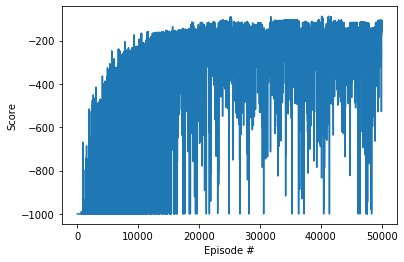

In [10]:
scores = train()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
# watch an trained agent
state = env.reset()
score = 0
for j in range(200):
    env.render()
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        print("Your total score is: ", score)
        break 
        
env.close()

Your total score is:  -112.0


In [14]:
data = {
    "Q1": agent.Q1,
    "Q2": agent.Q2,
    "scores": scores,
    "eps_start": eps_start
}
np.save("mountain_climb_doubleq.npy", data)